# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [ ]:
import gzip
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns
import typing as t

from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

FIGS_DIR: t.Final[Path] = Path("figures")
RUNS_DIR: t.Final[Path] = Path("../prod-runs/450-nodes/")

FIGS_DIR.mkdir(exist_ok=True)

Configuration

In [ ]:
local_ranks_per_task = {
    "run_molecular_dynamics": 8,
    "run_generator": 4,
    "train_generator": 1,
}

## Load in all results
Get them from each "-results.json" file

In [4]:
result_files = list(RUNS_DIR.glob("*-results.json"))
print(f"Found {len(result_files)} types of result files")

Found 4 types of result files


Store the create time, start time and end time for running, and node on which they were running

In [5]:
tasks = []
for result_file in result_files:
    task_type = result_file.name.split("-")[0]
    with open(result_file) as fp:
        for line in fp:
            row = json.loads(line)
            tasks.append(
                {
                    "task_type": task_type,
                    "method": row["method"],
                    "create_time": row["timestamp"]["created"],
                    "start_time": row["timestamp"]["compute_started"],
                    "end_time": row["timestamp"]["compute_ended"],
                    "span_running": row["time"]["running"],
                    "node": row["worker_info"]["hostname"],
                    "local_rank": int(row["worker_info"]["PARSL_WORKER_RANK"]),
                }
            )
tasks = pd.DataFrame(tasks)

In [6]:
print(tasks.groupby("method")["span_running"].count().to_csv())

method,span_running
assemble_many,6393
compute_partial_charges,297
process_ligands,38685
run_GCMC_single,225
run_generator,4778
run_molecular_dynamics,123702
run_optimization,305
train_generator,85



Normalize times by the time the first task was created

In [7]:
zero_time = tasks["create_time"].min()

In [8]:
time_cols = [c for c in tasks.columns if c.endswith("time")]
tasks[time_cols] -= zero_time

Assign node ids by the first time they received a task

In [9]:
node_names = []
compute = json.loads((RUNS_DIR / "compute-config.json").read_text())
for k, v in compute.items():
    if k.endswith("_hosts"):
        node_names.extend([x.split(".")[0] for x in v])
num_nodes = len(node_names)
print(f"Found {len(node_names)} nodes")

Found 450 nodes


In [10]:
tasks["node_id"] = tasks["node"].apply(node_names.index)

Assign a numerical task ID

In [11]:
methods = sorted(set(tasks["method"]))
tasks["task_id"] = tasks["method"].apply(methods.index)

In [12]:
methods

['assemble_many',
 'compute_partial_charges',
 'process_ligands',
 'run_GCMC_single',
 'run_generator',
 'run_molecular_dynamics',
 'run_optimization',
 'train_generator']

Get the node names for the CP2K workers

In [ ]:
cp2k_workers: list[list[int]] = []
for path in sorted(RUNS_DIR.joinpath("cp2k-hostfiles").glob("local_hostfile*")):
    cp2k_workers.append(
        [node_names.index(x.split(".")[0]) for x in path.read_text().split("\n")]
    )

../prod-runs/450-nodes


## Plot Assignment to Different Nodes
See how work is distributed.  [color pallete](https://coolors.co/f2545b-a93f55-0f7173-75f4f4-f9c22e)

Prepare to store a map of node id to task type

In [14]:
task_types = [0] * len(node_names)

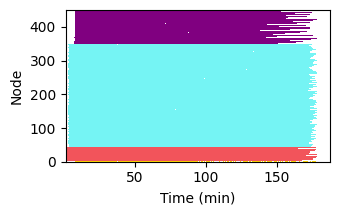

In [ ]:
color_map = [
    "black",  # Unknown
    "white",  # Helper task
    "white",  # Helper task
    "white",  # Helper task
    "white",  # Helper task
    "#F2545B",  # Generation
    "#75F4F4",  # Molecular Dynamics
    "purple",  # CP2K
    "gold",  # Training
]

fig, ax = plt.subplots(figsize=(3.5, 2.25))

for gid, group in tasks.groupby("method"):
    # Determine which nodes are covered
    if gid in [
        "process_ligands",
        "compute_partial_charges",
        "run_GCMC_single",
        "assemble_many",
    ]:
        continue
    elif gid in ["run_optimization"]:
        y = [min(cp2k_workers[l]) for l in group["local_rank"]]
        height = 2
        nodes = [i + j for j in range(height) for i in set(y)]
    else:
        num_ranks = local_ranks_per_task[gid]
        height = 1 / num_ranks
        offset = group["local_rank"] / num_ranks
        y = group["node_id"] + offset
        nodes = group["node_id"]

    task_type = group["task_type"].iloc[0]
    c = color_map[methods.index(gid) + 1]
    ax.barh(
        y=y,
        width=group["span_running"] / 60,
        left=group["start_time"] / 60,
        height=height,
        label=gid,
        color=c,
        align="edge",
    )

    for i in set(nodes):
        task_types[int(i)] = methods.index(gid) + 1

ax.set_ylabel("Node")
ax.set_ylim(0, num_nodes)
ax.set_xlabel("Time (min)")
fig.tight_layout()
plt.show()

## Summarize the GPU Utilization
Plot the amount of each GPU being used over time. Still color by task

In [ ]:
time_offset_from_UTC = (datetime.now() - datetime.utcnow()).total_seconds() / 3600.0
time_offset_from_UTC

utilization = []
for utilization_file in tqdm(RUNS_DIR.glob("logs/*.log")):
    # Pull in the total data
    util_data = pd.read_json(utilization_file, lines=True)
    util_data["time"] = (
        util_data["time"].apply(lambda x: datetime.fromisoformat(x).timestamp())
        - zero_time
        + time_offset_from_UTC * 3600
    )  # TZ Issue?
    node_name = utilization_file.name[:-4]
    util_data["node"] = node_name

    # Summarize the GPU utilization
    util_data["gpu_power"] = util_data["gpu_use"].apply(
        lambda row: [x["power.draw"] for x in row]
    )
    util_data["gpu_mem"] = util_data["gpu_use"].apply(
        lambda row: [x["memory.used"] for x in row]
    )
    util_data["gpu_use"] = util_data["gpu_use"].apply(
        lambda row: [x["utilization.gpu"] for x in row]
    )

    utilization.append(
        util_data[["time", "node", "cpu_use", "gpu_mem", "gpu_power", "gpu_use"]]
    )

utilization = pd.concat(utilization, ignore_index=True)

450it [00:40, 11.04it/s]


In [ ]:
for c in ["cpu", "gpu"]:
    utilization[f"{c}_use_total"] = utilization[f"{c}_use"].apply(np.sum)

utilization["gpu_power_total"] = utilization["gpu_power"].apply(np.sum)

Compile to a full-system utilization

In [ ]:
freq = 60  # How often to assess utilization
times = np.arange(0, utilization["time"].max(), step=freq)
utilization["node_id"] = utilization["node"].apply(node_names.index)

## Average GPU Utilization By Task
Average GPU utilization over all nodes running different types of tasks}

In [26]:
NODE_TYPE_TO_TASK_MAP: dict[int, tuple[str, str]] = {
    5: ("Generate Linkers (1 GPU)", "seagreen"),
    6: ("Validate Structure ($<1$ GPU)", "tomato"),
    7: ("Optimize Cells (Multi Node)", "darkgoldenrod"),
    8: ("Retrain (Single Node)", "darkorchid"),
}

Group by Node Type

In [ ]:
utilization["node_id"] = utilization["node"].apply(node_names.index)
utilization["node_type"] = utilization["node_id"].apply(task_types.__getitem__)
utilization.head()

,time,node,cpu_use,gpu_mem,gpu_power,gpu_use,cpu_use_total,gpu_use_total,gpu_power_total,node_id,node_type
0,2.754160,x3105c0s19b0n0,"[0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0,...","[31, 31, 31, 31]","[55, 51, 55, 53]","[0, 0, 0, 0]",25.0,0,214,96,6
1,23.430042,x3105c0s19b0n0,"[5.0, 0.30000000000000004, 0.5, 0.0, 0.6000000...","[31, 31, 31, 31]","[55, 51, 55, 53]","[0, 0, 0, 0]",89.9,0,214,96,6
2,44.105036,x3105c0s19b0n0,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.1, ...","[31, 31, 31, 31]","[55, 51, 55, 53]","[0, 0, 0, 0]",14.7,0,214,96,6
3,64.787023,x3105c0s19b0n0,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.0, ...","[31, 31, 31, 31]","[55, 51, 55, 53]","[0, 0, 0, 0]",11.6,0,214,96,6
4,85.462834,x3105c0s19b0n0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.0, ...","[31, 31, 31, 31]","[55, 51, 55, 53]","[0, 0, 0, 0]",14.6,0,214,96,6


5
6
7
8


/var/folders/kn/2_n0f_tn41j9_rj_8lcvx4g00000gn/T/ipykernel_6068/4091444571.py:91: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(


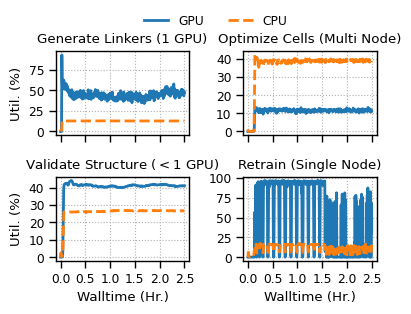

In [ ]:
node_type_to_axes: dict[int, tuple[int, int]] = {
    5: (0, 0),  # Generate Linkers (1 GPU)
    6: (1, 0),  # Validate Structure ($<1$ GPU)
    7: (0, 1),  # Optimize Cells (Multi Node)
    8: (1, 1),  # Retrain (Single Node)
}

with sns.plotting_context("paper", font_scale=1.0):
    fig, axes = plt.subplots(
        2,
        2,
        figsize=(4.0, 3.0),
        sharex=True,
    )

    times = np.linspace(0, 2.5 * 3600, 1024)
    xlim_padding = 0.1
    axes[0, 0].set_xlim([0 - xlim_padding, 2.5 + xlim_padding])

    for node_type, group in utilization.groupby("node_type"):
        idx = node_type_to_axes[node_type]
        ax = axes[idx]

        # Get the name and color used
        if node_type not in NODE_TYPE_TO_TASK_MAP:
            continue

        label, color = NODE_TYPE_TO_TASK_MAP[node_type]
        color = "tab:blue"
        ax.set_title(label)

        # Make interpolators over each node
        gpu_interps = []
        for nid, subgroup in group.groupby("node"):
            gpu_interps.append(
                interp1d(
                    subgroup["time"],
                    subgroup["gpu_use"].apply(np.mean),
                    fill_value=0,
                    bounds_error=False,
                )
            )

        # Compute the average over the 3 hours of the run
        gpu_util = [np.mean([f(t) for f in gpu_interps]) for t in times]

        # Plot
        ax.plot(
            times / 3600,
            gpu_util,
            color=color,
            label=label,
            linestyle="-",
            lw=2,
        )
        ax.set_ylabel("GPU (%)")

        # Do the same for CPU
        color = "tab:orange"
        cpu_interps = []
        for nid, subgroup in group.groupby("node"):
            cpu_interps.append(
                interp1d(
                    subgroup["time"],
                    subgroup["cpu_use"].apply(lambda x: np.sum(x) / 32),
                    fill_value=0,
                    bounds_error=False,
                )
            )
        cpu_util = [np.mean([f(t) for f in cpu_interps]) for t in times]
        ax.plot(
            times / 3600,
            cpu_util,
            color=color,
            label=label,
            linestyle="--",
            lw=2,
        )
        ax.set_ylabel("CPU (%)")

        ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
        ax.grid(linestyle=":")

    axes[0, 0].set_yticks([0, 25, 50, 75])
    axes[0, 1].set_yticks([0, 10, 20, 30, 40])
    axes[1, 0].set_yticks([0, 10, 20, 30, 40])
    axes[1, 1].set_yticks([0, 25, 50, 75, 100])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        ncol=2,
        labels=["GPU", "CPU"],
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.55, 1.05),
    )

    for i in range(2):
        axes[i, 0].set_ylabel("Util. (%)")
        axes[i, 1].set_ylabel("")

    for j in range(2):
        axes[1, j].set_xlabel("Walltime (Hr.)")

    plt.tight_layout()
    plt.savefig(FIGS_DIR / "fig4.pdf", bbox_inches="tight")
    plt.show()